<a href="https://colab.research.google.com/github/Croftc/kmeans-vector-quantization/blob/main/kmeans-vector-quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 3: Using K-means Clustering for Vector Quantization
# CMSC 422, Fall 2020
# Due Oct 15 at 3:30pm

## Submission Instructions

**Once** you have completed the problems, download this Colab notebook **as a notebook file** by navigating to `File > Download .ipynb`, and submit it on Gradescope. This assignment will be autograded so follow instructions closely.  __Note:__ Using anything other then `matplotlib` for your plots may crash the autograder. Also, make sure none of your code cells are throwing exceptions.

## Overview
This problem set focuses on K-means clustering.  This algorithm is described in Section 3.4 of Daume's book, with an improved version and some theoretical results given in Section 15.1.  We are given vectors in a high-dimensional space. Our goal is to identify k cluster centers and an assignment of vectors, one to each cluster, that minimizes the sum of squared distance from the vectors to their corresponding cluster centers.

We illustrate this using an important application of clustering to vector quantization.  We will experiment with this in the context of images.  An image consists of pixels.  Each pixel has a red, green and blue value, which are typically represented with 8 bit unsigned integers.  This means every color has a value between 0 and 255.  If we represent these values explicitly, we need 24 bits for every pixel in the image.  If our image has N pixels, we need 24N bits.

But suppose our image only contained 256 distinct colors.  In that case, we could represent the image with much less space.  We would just need a table of 256 colors.  Then, for every pixel we could describe its color with an index into this table.  Representing such a table requires 256*24 bits, while representing the indices requires 8N bits.  Since N is typically very large (megapixel cameras are ubiquitous), we would reduce the size of our image by about a factor of 3.

But real images don't have 256 different colors, they may have millions of different colors.  But many of these colors are pretty similar, so we can often approximate an image with a small number of colors.  We want to do this with as little distortion of the true colors as possible.  K-means is perfect for this.  The cluster centers will be the colors we put in the table.  The assignment of pixels to cluster centers will tell us what color to use in the approximate image for each pixel.  And the objective function of K-means is a way of saying we want to find the colors for the table and a way of assigning pixels to these colors that minimizes the distortion of the image.

## Getting started with images


We begin by importing some standard libs.  cv2 is OpenCV, a standard library used for computer vision.

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

Click on the links below and download the images we will be working with:
- [peppers.jpg](https://drive.google.com/file/d/1aN2c8mp72qCrQn7_3CecCv9HgzpqAc82/view?usp=sharing)
- [peppers_small.jpg](https://drive.google.com/file/d/143lBsMzNjLJAagaeva6Zooj2OpT1I0bG/view?usp=sharing)

Next, this code allows you to select a file to load on your computer.  Use it to load the two images you have downloaded, peppers.jpg and peppers_small.jpg.  We suggest that you do all experiments with peppers_small.jpg.  When everything is working you can run with peppers.jpg to see how things look.

In [ ]:
from google.colab import files
uploaded = files.upload()  # (you can select more than one file)

Saving peppers_small.jpg to peppers_small.jpg
Saving peppers.jpg to peppers.jpg


The next code reads the images into Python, and shows how to display them.

In [ ]:
imgsmall = cv2.imread('peppers_small.jpg')
img = cv2.imread('peppers.jpg')

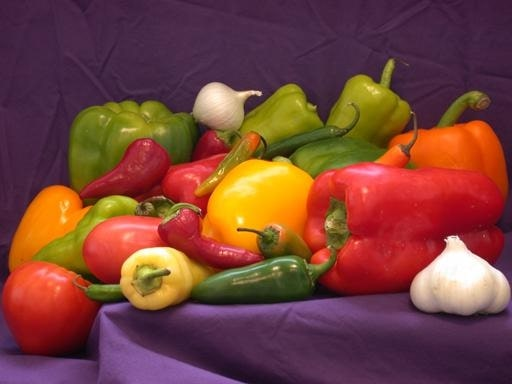

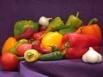

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2_imshow(imgsmall)

Each image is a 3D array.  For every (x,y) position there is a pixel, and every pixel contains three values.  These are RGB values (red, green, blue), which say how much of each color is in a pixel.

In [ ]:
x,y,z = imgsmall.shape

In [ ]:
[x,y,z]

[77, 103, 3]

See, the small image has 77 rows and 103 columns, and 3 values for each pixel.  We can access a pixel value just by indexing into it.  For example:

In [ ]:
[img[0,0,0], img[0,0,1], img[0,0,2]]

[62, 31, 64]

The pixel in the upper left corner is kind of purple.  It's dark, but it has a fair amount of R (red) and B (blue), and less G (green).  

## Problem 1 (15 points)



We'll begin by writing code to compute the distance from each pixel to a cluster center.


In [ ]:
def cluster_points_distance_squared(cl, img):
  # img is an rxcx3 array.  
  # cl is a 1x3 array, containing the rgb values of a cluster center.
  # The function shold return a rxc array, in which each entry gives the squared
  # distance from the corresponding pixel to cl.
  # ADD YOUR CODE BELOW
  #return np.linalg.norm(img-cl,ord=1, axis=2)
  orig_shape = img.shape
  t = img.reshape(-1,3)
  dists = []
  for v in t:
    dists.append(np.sum((cl-v)**2))

  dists = np.asarray(dists)
  return dists.reshape(orig_shape[0],orig_shape[1])


Just to test this, here's the output of our code on a simple problem:

In [ ]:
testim = np.empty([2,2,3])
testim2 = imgsmall
testim[0,0,0:3] = [1,0,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,0,1]
testim[1,1,0:3] = [1,1,1]
cl = np.array([1,0,1])
#cl2 = simple_init(1)
cluster_points_distance_squared(cl, testim)



array([[1., 3.],
       [1., 1.]])

The output looks like:  
array([[1., 3.],
       [1., 1.]])

## Problem 2 (15 Points)

Now, implement a function to decide what cluster each pixel belongs to.  You'll compute the distance from each cluster center to each pixel, and assign each pixel to the nearest cluster.  One corner case that can arise is when a pixel is equidistant to two or more cluster centers.  This can be handled in a variety of ways.  Normally, it's not too important how you deal with this.  But to make it easier for us to test your code, we will require that such a pixel be assigned to the cluster that comes first in the list, cls, which is input to the function.

In [ ]:
def cluster_members(cls, img):
  # cls is a list of cluster centers.  Every item in cls is a 1x3 array indicating the center of a cluster
  # img is an image, represented as a rxcx3 array.
  # The function should return an rxc array.  Each entry in the array is an integer
  # giving the index of the cluster that the corresponding pixel belongs to.  
  # That is, if we call the output of the function asgn, then asgn[y,x] should
  # contain an integer so that cls[asgn[y,x]] contains the RGB values of the cluster
  # that pixel [y,x] belongs to.
  # ADD YOUR CODE BELOW
  #print(cls)
  dists = []
  img2 = img.reshape(-1,3)
  nc = []
  #print(dists)

  # for each cluster
  for cl in cls:

    # get distance to all points
    d = cluster_points_distance_squared(cl, img)
    dists.append(d)

  dists = np.asarray(dists)
  dists = np.stack(dists, axis=(-1))

  for mat in dists:
    ncs = []
    for row in mat:
      ncs.append(np.argmin(row))
    nc.append(ncs)
  return np.asarray(nc)
  


Ok, just to check this, we run on a simple test case.  

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [1,1,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,1,1]
testim[1,1,0:3] = [0,0,1]
cl0 = np.array([.3,.8,0])
cl1 = np.array([0, .1, .8])
cl2 = np.array([.2, 0, .7])
cls = [cl0, cl1]
cls[1]
asgn = cluster_members(cls, testim)
asgn


array([[0, 0],
       [1, 1]])

The result of running this code is:

array([[0, 0],
       [1, 1]])

## Problem 3 (20 Points)


Next, write a function that will update the centers of the clusters, based on cluster assignments that have been computed. Each cluster center should be updated to be the average of the pixels assigned to that center.

Note that it is possible that a cluster will contain no pixels.  That is ok, but must be handled without your code blowing up.  One might deal with this issue in a few different ways.  For simplicity, in your code, just assign the cluster a center of [-255,-255,-255].  This will result in the cluster being out of action, and not having any pixels assigned to it in the future.  

In [ ]:
def update_centers(asgn, img, k):
  # asgn contains an image-sized 2D array containing the index of the clusters 
  # that each pixel is assigned to, as in the output of cluster_members.
  # img is the image.
  # k is the number of cluster centers.
  # Return a list of cluster centers.  Each center is a 1x3 array.
  # ADD YOUR CODE BELOW
  empty = np.array([-255,-255,-255])
  map = {}
  for i in range(k):
    map[i] = []

  for ri,row in enumerate(asgn):
    for ci,col in enumerate(row):
      if col in map:
        map[col].append(img[ri][ci])

  ccs = []
  for key, value in map.items():
    if value == []:
      map[key] = empty
    else:
      map[key] = np.mean(value,axis=0)
    ccs.append(map[key])

  return np.asarray(ccs)





Again, we'll try this on a simple example, using the results from the last example:

In [ ]:
cls = update_centers(asgn, testim, 2)
cls



{0: [array([0., 0., 0.]), array([2., 0., 0.])], 1: [array([6., 0., 0.]), array([8., 0., 0.])]}


array([[1., 0., 0.],
       [7., 0., 0.]])

The answer that our code produces is:

[array([0.5, 1. , 0. ]), array([0. , 0.5, 1. ])]

## Problem 4 (10 points)

Now we will put these functions together to perform k-means clustering.  You will define a function that takes as input the initial values of the clusters. We provide a simple initialization method.  This makes it easier to test your code.

Also, in k-means one might test to see if the algorithm has converged.  However, to keep things simple, we will just ask you to iterate a fixed number of times, so you don't need to bother testing.  

In [ ]:
def initialized_k_means(cls, img, n):
  # cls is a list of arrays containing the initial cluster centers.
  # img is an image.
  # n is the number of iterations.  Must be > 0 (can assume valid input)
  # This function will return two values (a tuple).
  # First, it will return a list of the final cluster centers.
  # Second, it will return an array show the final assignments of pixels to clusters.
  # ADD YOUR CODE BELOW
  clusters = cls
  for i in range(n):
    asgn = cluster_members(clusters, img)
    clusters = update_centers(asgn, img, len(cls))
  return (clusters, asgn)





Ok, a simple example:

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [0,0,0]
testim[0,1,0:3] = [2,0,0]
testim[1,0,0:3] = [6,0,0]
testim[1,1,0:3] = [8,0,0]
cl0 = np.array([1,0,0])
cl1 = np.array([8, 6, 0])
cls = [cl0, cl1]
cls1, asgn1 = initialized_k_means(cls, testim, 1)
print(cls1)
print(asgn1)
cls2, asgn2 = initialized_k_means(cls, testim, 2)
print(cls2)
print(asgn2)

[[2.66666667 0.         0.        ]
 [8.         0.         0.        ]]
[[0 0]
 [0 1]]
[[1. 0. 0.]
 [7. 0. 0.]]
[[0 0]
 [1 1]]


The result of our code is:

[array([2.66666667, 0.        , 0.        ]), array([8., 0., 0.])]
[[0 0]
 [0 1]]
[array([1., 0., 0.]), array([7., 0., 0.])]
[[0 0]
 [1 1]]

## Problem 5 (25 Points)

Ok, we are now ready to quantize an image.  We will provide a baseline function to initialize the cluster centers, and a function to measure how close the quantized image is from the original image, to allow evaluation. 

In [ ]:
###########################
# DO NOT MODIFY THIS CELL #
###########################

def simple_init(k):
  # Function will return a list of k classes.
  # Note that rgb values are between 0 and 255.
  np.random.seed(42)
  cls = [];
  for i in range(k):
    cls += [np.random.randint(0,256,3)]
  return cls

def compare_images(img1, img2):
  return np.sqrt(np.sum((img1-img2)**2))


In [ ]:
def quantize_image(img, k, n):
  # This takes an image, img, a number of cluster, k, and a number of iterations, n.
  # k should be the cube of an integer (eg., 8, 27, 64, ....)
  # It returns a new image.  The new image should have only k unique clusters.
  # It also returns a list of the cluster centers. Like before, return them as 
  # a tuple.
  # ADD YOUR CODE BELOW
  cls = simple_init(k)
  cls, asgn = initialized_k_means(cls, img, n)
  cls = np.asarray(cls).astype(int)
  newimg = np.ndarray(img.shape)
  for ri,row in enumerate(asgn):
    for ci,col in enumerate(row):
      newimg[ri][ci] = cls[col]

  return (newimg,np.asarray(cls))

Now we can run this code on a real image.  We can see that when we use 128 colors, we get something that looks pretty similar to the original image.  With 8 colors, there are noticeable artifacts, but we have a comprehensible image.  This might be useful for very compact thumbnails.

{0: [array([ 61, 150, 160], dtype=uint8), array([ 58, 155, 165], dtype=uint8), array([ 64, 140, 159], dtype=uint8), array([ 68, 146, 159], dtype=uint8), array([ 74, 146, 158], dtype=uint8), array([ 52, 136, 148], dtype=uint8), array([ 56, 156, 168], dtype=uint8), array([ 50, 158, 170], dtype=uint8), array([ 51, 137, 149], dtype=uint8), array([ 46, 144, 154], dtype=uint8), array([ 43, 141, 151], dtype=uint8), array([ 55, 147, 160], dtype=uint8), array([ 43, 151, 163], dtype=uint8), array([ 47, 145, 161], dtype=uint8), array([ 53, 141, 157], dtype=uint8), array([ 64, 147, 162], dtype=uint8), array([ 49, 145, 158], dtype=uint8), array([ 74, 151, 160], dtype=uint8), array([ 71, 146, 155], dtype=uint8), array([ 54, 150, 163], dtype=uint8), array([ 60, 139, 152], dtype=uint8), array([ 44, 140, 153], dtype=uint8), array([ 45, 143, 149], dtype=uint8), array([ 53, 151, 157], dtype=uint8), array([ 54, 140, 152], dtype=uint8), array([ 47, 139, 152], dtype=uint8), array([ 61, 140, 137], dtype=uint

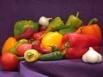

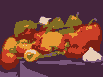

3000.3963071567728


In [ ]:
np.core.arrayprint._line_width = 800
np.set_printoptions(edgeitems=20)
qimgsmall8, cls8 = quantize_image(imgsmall, 8, 10)
# qimgsmall256, cls256 = quantize_image(imgsmall, 256, 10)
cv2_imshow(imgsmall) 
cv2_imshow(qimgsmall8)
# cv2_imshow(qimgsmall256)
#print(compare_images(imgsmall, qimgsmall8))
# print(compare_images(imgsmall, qimgsmall256))

We can look at this on the full-sized image too, though this is going to take a lot longer to run (took me around 30 minutes).

In [ ]:
qimg8, cls8 = quantize_image(img, 8, 10)
qimg128, cls128 = quantize_image(img, 128, 10)
cv2_imshow(img) 
cv2_imshow(qimg8)
cv2_imshow(qimg128)
print(compare_images(img, qimg8))
print(compare_images(img, qimg128))


KeyboardInterrupt: ignored

## Problem 6 (15 Points)

Finally, the last problem is to find a way to improve on these results.  That is, you need to find a way to improve k-means so that it produces a better image, using the same number of clusters (that is, you shouldn't improve the result by just increasing k).

Your improvements should not be specific to the pepper image.  We will test your code on three new images.  To get full credit, your result must be better on all three than the code we write as the answer to Problem 5.  One way of doing this is suggested in the text by Daume.  

In [ ]:
def init_centers(img,k):
  mu1 = simple_init(1)
  cls = [mu1]
  dists = []
  points = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
  for k in range(2,k+1):
    for p in points:
      min_dist = 99999999
      for cl in cls:
        d = np.sum((cl-p)**2)
        if d < min_dist:
          min_dist = d
      dists.append(min_dist)
        
    cls.append(points[np.argmax(dists)])
    dists = []
  return cls
    


def better_quantize_image(img, k, n):
  cls = init_centers(img,k)
  cls, asgn = initialized_k_means(cls, img, n)
  cls = np.asarray(cls).astype(int)
  newimg = np.ndarray(img.shape)
  for ri,row in enumerate(asgn):
    for ci,col in enumerate(row):
      newimg[ri][ci] = cls[col]

  return (newimg,np.asarray(cls))

Here is an example showing our codes performance

[[array([102, 179,  92])], array([251, 255, 255], dtype=uint8), array([70, 41, 74], dtype=uint8), array([ 48, 114, 113], dtype=uint8), array([17, 21, 86], dtype=uint8), array([ 26,  68, 229], dtype=uint8), array([101, 139, 157], dtype=uint8), array([  9,  56, 184], dtype=uint8), array([62, 21, 48], dtype=uint8), array([ 40,  35, 188], dtype=uint8), array([123,  70, 113], dtype=uint8), array([ 26, 127, 243], dtype=uint8), array([150,  80, 127], dtype=uint8), array([ 56, 102, 203], dtype=uint8), array([239, 243, 255], dtype=uint8), array([ 31,  13, 142], dtype=uint8)]


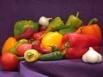

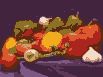

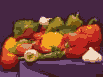

2575.113201395232
2266.5050187458223


In [ ]:

qimgsmall1, cls1 = quantize_image(imgsmall, 16, 10)
qimgsmall2, cls2 = better_quantize_image(imgsmall, 16, 10)
cv2_imshow(imgsmall) 
cv2_imshow(qimgsmall1)
cv2_imshow(qimgsmall2)
print(compare_images(imgsmall, qimgsmall1))
print(compare_images(imgsmall, qimgsmall2))